
##### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten,Conv2D, MaxPooling2D,Dropout, BatchNormalization
from keras.models import  Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

##### Load the training data

In [4]:
train = pd.read_csv(r"data/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The 1st column is the label (y) <br>
2nd column onwards (pixel0 to pixel783) are the pixel values ranging from 0 - 255

In [5]:
#Splitting X and y variables
X = (train.iloc[:,1:].values).astype('float32')
y = (train.iloc[:,0].values).astype('int32')


In [6]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (42000, 784)
y shape: (42000,)


##### Plotting random samples

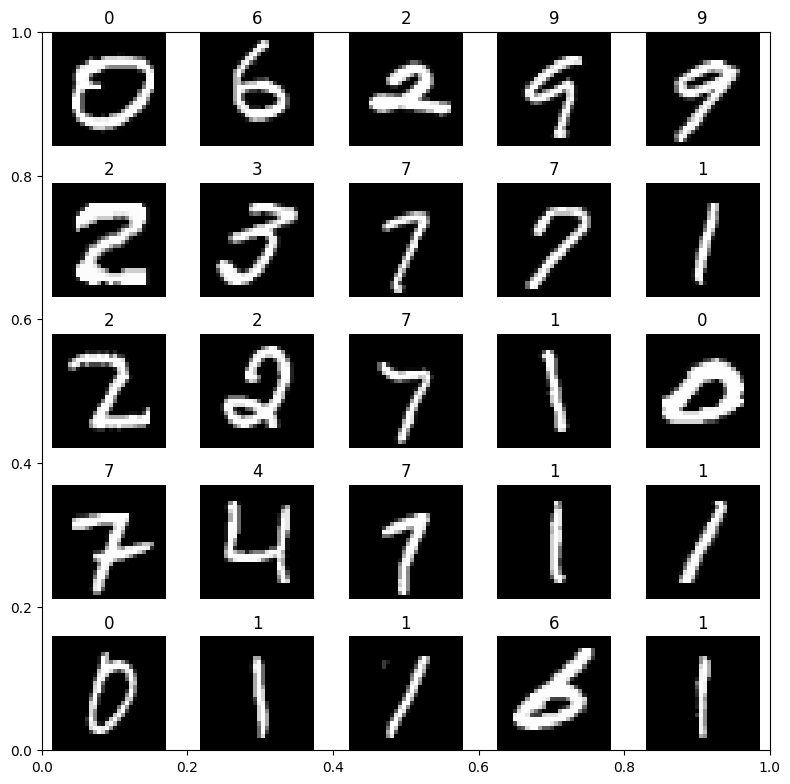

In [7]:

np.random.seed(42)

#Creating a list of 25 random integer numbers from the training set
random_indices = np.random.randint(0, X.shape[0], 25)

#Adding the images and label at randomly generated index to the lists
images=[]
labels=[]
for i in random_indices:
    images.append(X[i].reshape((28,28,1)))
    labels.append(y[i])

# Plot the images
plt.subplots(figsize = (8, 8))
for i, image in enumerate(images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(labels[i])
    plt.axis('off')


plt.tight_layout()
plt.show()

In [8]:
#Dividing X by 255 and reshaping 
X = X/255.0
X = X.reshape(-1,28,28,1)

#One hot encoding the output variables
y = to_categorical(y, num_classes=10)

In [9]:
print("X shape: ",X.shape)
print("Y shape: ",y.shape)

X shape:  (42000, 28, 28, 1)
Y shape:  (42000, 10)


In [10]:
#Splitting into train and validation sets


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 33600
Validation samples: 8400


##### Modelling

In [20]:
class DigitClassification:

    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        self.model = Sequential([
            Conv2D(64, kernel_size=(3, 3), padding='Same', activation='tanh', input_shape=(28, 28, 1)),
            Conv2D(64, kernel_size=(3, 3), padding='Same', activation='tanh'),
            MaxPooling2D(2, 2),
            BatchNormalization(),

            Conv2D(128, kernel_size=(3, 3), padding='Same', activation='tanh'),
            Conv2D(128, kernel_size=(3, 3), padding='Same', activation='tanh'),
            MaxPooling2D(2, 2),
            BatchNormalization(),

            Conv2D(filters=256, kernel_size=(3, 3), activation="tanh"),
            MaxPooling2D(2, 2),
            BatchNormalization(),

            Flatten(),
            Dense(512, activation="tanh"),
            Dropout(0.5),
            Dense(10, activation="softmax"),
        ])

        return self.model

    def compile_model(self, learning_rate=0.001):
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


    def train_model(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1,mode="max", restore_best_weights=True)
        
        history = self.model.fit(x = X_train,y=y_train,batch_size=batch_size, epochs=epochs,validation_data=(X_val,y_val), callbacks=[early_stopping])
        return history

    def evaluate_model(self, X_test, y_test):
      return self.model.evaluate(X_test, y_test)
    
    def predict_model(self, X_test):
        return self.model.predict(X_test)
    
    def summary(self):
        return self.model.summary()



##### Understanding the model layers

1. Convolution layer - This layer performs a linear opperation involving the multiplication of the input with an array of weights called the kernel. Here we use a kernel of size 3 by 3. This layer is used for extrating features from the input.

2. Pooling layer - This is used for downsampling the feature map obtained from the previous layer. There are multiple types of pooling like, max pooling, average pooling etc.

3. Batch Normalization layer - During training, the weights of each layer are updated frequently. Because of this update the distribution of the weights is also likely to change (This change is called internal covarivate shift). This change may slow down the training process. This layer helps in reducing the effects of the internal covarivate shift.  

4. Flatten layer - The feature map that has been generated through multiple convolution, pool and batch normalization layers is given here as input. This coverts the input to a 1D layer. IF the input is n by m array then the output is a 1D array with n*m elements.

5. Dense layer - It performs a multiplication of the input with weights and adds bias to it. After this the activation function is applied. Therefore the output is activation(weights*input + bias). Here we are using 'relu' activation function. 

6. Dropout - This layer is used to nullify the contribution of some neurons to the next layer. The number of neurons is decided by a value which is passed as a parameter. Here we are using 0.5 which means half of the neurons will deactivated.

In [21]:
digitClassifier = DigitClassification()
digitClassifier.compile_model()

history = digitClassifier.train_model(X_train, y_train,X_val, y_val,batch_size=256, epochs=20)


Epoch 1/20
132/132 [==============================] - 88s 653ms/step - loss: 0.2240 - accuracy: 0.9310 - val_loss: 2.4037 - val_accuracy: 0.3812
Epoch 2/20
132/132 [==============================] - 90s 680ms/step - loss: 0.0609 - accuracy: 0.9811 - val_loss: 0.3880 - val_accuracy: 0.8874
Epoch 3/20
132/132 [==============================] - 92s 697ms/step - loss: 0.0479 - accuracy: 0.9844 - val_loss: 0.1185 - val_accuracy: 0.9640
Epoch 4/20
132/132 [==============================] - 90s 684ms/step - loss: 0.0343 - accuracy: 0.9893 - val_loss: 0.0568 - val_accuracy: 0.9827
Epoch 5/20
132/132 [==============================] - 94s 709ms/step - loss: 0.0225 - accuracy: 0.9931 - val_loss: 0.0522 - val_accuracy: 0.9857
Epoch 6/20
132/132 [==============================] - 97s 735ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0668 - val_accuracy: 0.9811
Epoch 7/20
132/132 [==============================] - 96s 727ms/step - loss: 0.0171 - accuracy: 0.9940 - val_loss: 0.0625 - val_ac

In [13]:
digitClassifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       5

We can verify the input and output shapes for individual layers using the following equations.

CONVOLUTION LAYER:
$$
Output Size = \frac{Input Size− KernelSize + 2×Padding}{Stride} + 1
$$

MAX POOLING:
$$
Output Size = \frac{Input Size− PoolSize}{Stride} + 1
$$

BATCH NORMALIZATION:
$$
Inputsize = OutputSize
$$

##### Testing the model on training, validation and testing set

Train Set

In [14]:
print("**********Evaluation on training set**********")
train_loss,train_accuracy = digitClassifier.evaluate_model(X_train, y_train)
print(f"Loss: {train_loss}, Accuracy: {train_accuracy}")

**********Evaluation on training set**********
1050/1050 [==============================] - 81s 77ms/step - loss: 0.0122 - accuracy: 0.9969
Loss: 0.012239789590239525, Accuracy: 0.996874988079071


Validation set

In [15]:
print("**********Evaluation on validation set**********")
train_loss,train_accuracy = digitClassifier.evaluate_model(X_val, y_val)
print(f"Loss: {train_loss}, Accuracy: {train_accuracy}")

**********Evaluation on validation set**********


263/263 [==============================] - 20s 77ms/step - loss: 0.0397 - accuracy: 0.9924
Loss: 0.03971182927489281, Accuracy: 0.9923809766769409


Testing set and submission

In [16]:
X_test = pd.read_csv(r"data/test.csv")
submission = pd.read_csv(r"data/sample_submission.csv")

In [17]:
#Dividing X by 255 and reshaping 
X_test = X_test/255.0
X_test = X_test.values.reshape(-1,28,28,1)

In [18]:
y_pred = digitClassifier.predict_model(X_test)
y = np.argmax(y_pred, axis=1)
submission['Label'] = y
submission.to_csv(r'data/submission.csv', index= False)

875/875 [==============================] - 66s 75ms/step


##### Plotting test samples

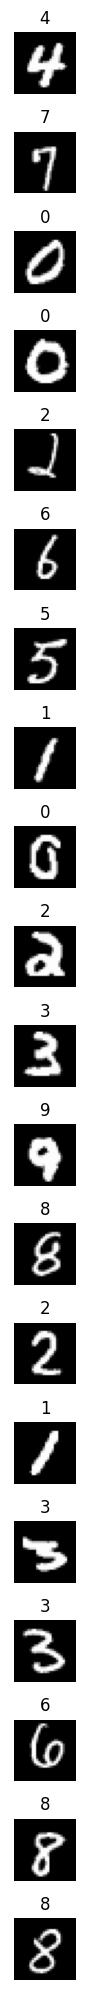

In [19]:

np.random.seed(42)
num_random_images = 20
#Creating a list of 10 random integer numbers from the testtig set
random_indices = np.random.randint(0, X_test.shape[0], num_random_images)

#Adding the images and label at randomly generated index to the lists
images=[]
labels=[]
for i in random_indices:
    images.append(X_test[i].reshape((28,28,1)))
    labels.append(y[i])

# Plot the images
plt.subplots(figsize = (1,num_random_images))
plt.axis('off')
for i, image in enumerate(images):
    plt.subplot(num_random_images,1 , i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(labels[i])
    plt.axis('off')


plt.tight_layout()
plt.show()